# 신경망
## 신경망의 구조
- 네트워크(모델)를 구성하는 층(layer)
- 입력 데이터와 타깃
- 손실함수(학습에 사용할 피드백 신호 정의)
- 옵티마이저(학습 진행 방식 결정)
### 층: 딥러닝의 구성 단위
하나 이상의 텐서를 입력으로 받아 하나 이상의 텐서를 출력하는 데이터 처리 모듈  
-> 특정 층은 상태가 없지만, 대부분 가중치라는 상태를 갖음

층마다 적절한 텐서 포멧과 데이터 처리 방식이 다름  
- 2D 텐서: FC(완전 연결 층), 밀집층(Dense)
- 3D 텐서: 순환층(Recurrent)
- 4D 텐서: 합성곱층(Convolution)

### 모델: 층의 네트워크
딥러닝 모델은 층으로 만든 비순환 유향 그래프(DAG, Directed Acyclic Graph)임  

### 손실 함수와 옵티마이저: 학습 과정을 조절
#### 손실 함수(loss function) / 목적 함수(objective function)
훈련하는 동안 최소화될 값
#### 옵티마이저(optimier)
손실 함수를 기반으로 네트워크가 어떻게 업데이트될지 결정  
일반적으로, 특정 종류의 SGD를 구현

## 이진 분류 예제 - 영화 리뷰 분류
### 데이터 준비

In [1]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 1s 0us/step


In [8]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [9]:
train_labels[0]

1

신경망에 숫자 리스트를 넣을 수는 없음 -> 텐서 형태로 변환해야함  
- 패딩 추가 (Embedding 층)
- 원-핫 인코딩(one-hot encoding)

In [10]:
# 원-핫 인코딩 방식 이용
import numpy as np

def vectorize_sequence(sequence, dimension=10000):
    result = np.zeros((len(sequence), dimension))
    for i, sequence in enumerate(sequence):
        result[i, sequence] = 1.
    return result

x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)

In [12]:
x_train[0][:10]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

In [13]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### 신경망 모델 생성

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation="relu", input_shape=(10000,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

활성화 함수(비선형성(non-linearity))가 없다면 Dense 층은 선형적인 연삭인 점곱과 덧셈으로만 이뤄짐  
-> 선형 변환(아핀 변환)만을 학습할 수 있음  

In [15]:
model.compile(
    optimizer = "rmsprop",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [19]:
# 동일 코드
import tensorflow as tf

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss = tf.keras.losses.binary_crossentropy,
    metrics = [tf.keras.metrics.binary_accuracy]
)

### 훈련

In [20]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [21]:
with tf.device(":/GPU:0"): # GPU 사용 설정
    history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 41ms/step - loss: 0.5203 - binary_accuracy: 0.7885 - val_loss: 0.3932 - val_binary_accuracy: 0.8583
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3090 - binary_accuracy: 0.9023 - val_loss: 0.3157 - val_binary_accuracy: 0.8824
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2248 - binary_accuracy: 0.9280 - val_loss: 0.2780 - val_binary_accuracy: 0.8922
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1804 - binary_accuracy: 0.9405 - val_loss: 0.2756 - val_binary_accuracy: 0.8924
Epoch 5/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1450 - binary_accuracy: 0.9534 - val_loss: 0.3132 - val_binary_accuracy: 0.8776
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1213 - binary_accuracy: 0.9641 - val_loss: 0.3062 - val_binary_accuracy: 0.8808
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - los

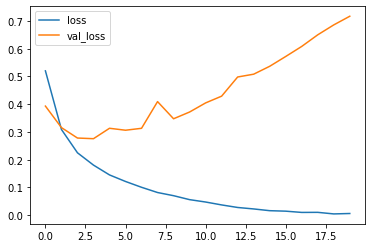

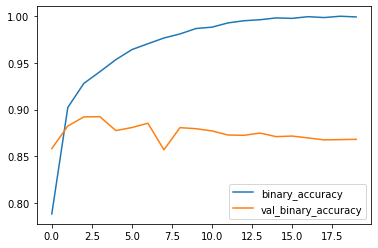

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df_hist = pd.DataFrame(history.history)
df_hist[["loss", "val_loss"]].plot()
df_hist[["binary_accuracy", "val_binary_accuracy"]].plot()
plt.show()

### 예측하기

In [26]:
model.predict(x_test)

782/782 [==============================] - 1s 1ms/step


array([[0.00591868],
       [1.        ],
       [0.98497665],
       ...,
       [0.00201654],
       [0.01618378],
       [0.8328961 ]], dtype=float32)

긍정 리뷰일 확률을 반환함

## 다중 분류 예제 - 뉴스 기사 분류
### 데이터 준비

In [44]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [45]:
x_train = vectorize_sequence(train_data)
x_test = vectorize_sequence(test_data)

In [46]:
# 내장 함수를 이용하는 경우
from tensorflow.keras.utils import to_categorical

oh_train_labels = to_categorical(train_labels)
oh_test_labels = to_categorical(test_labels)

### 모델 구성

In [47]:
len(np.unique(test_labels))

46

In [48]:
model = Sequential()
model.add(Dense(64, activation="relu", input_shape=(10000, )))
model.add(Dense(64, activation="relu"))
model.add(Dense(46, activation="softmax"))

In [53]:
model.compile(
    optimizer = "rmsprop",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

### 훈련 검증

In [54]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = oh_train_labels[:1000]
partial_y_train = oh_train_labels[1000:]

In [55]:
with tf.device(":/GPU:0"):
    history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 23ms/step - loss: 2.5931 - accuracy: 0.4746 - val_loss: 1.7548 - val_accuracy: 0.6520
Epoch 2/20
16/16 [==============================] - 0s 17ms/step - loss: 1.4322 - accuracy: 0.7131 - val_loss: 1.3396 - val_accuracy: 0.7110
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 1.0664 - accuracy: 0.7794 - val_loss: 1.1794 - val_accuracy: 0.7410
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 0.8446 - accuracy: 0.8213 - val_loss: 1.0708 - val_accuracy: 0.7770
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6730 - accuracy: 0.8557 - val_loss: 0.9995 - val_accuracy: 0.8020
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.5401 - accuracy: 0.8850 - val_loss: 0.9542 - val_accuracy: 0.8140
Epoch 7/20
16/16 [==============================] - 0s 16ms/step - loss: 0.4322 - accuracy: 0.9083 - val_loss: 0.9355 - val_accuracy: 0.8160
Epoch 8/20
16

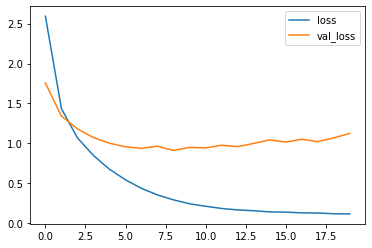

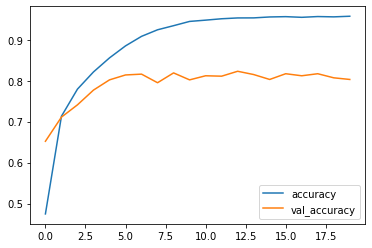

In [56]:
df_hist = pd.DataFrame(history.history)
df_hist[["loss", "val_loss"]].plot()
df_hist[["accuracy", "val_accuracy"]].plot()
plt.show()

### 예측

In [57]:
pred = model.predict(x_test)

71/71 [==============================] - 0s 2ms/step


In [59]:
pred[0].shape

(46,)

In [60]:
np.sum(pred[0])

0.99999976

In [61]:
np.argmax(pred[0])

3

46개의 레이블 각각에 대한 확률을 반환하고, 가장 높은 확률을 갖는 레이블을 최종 예측값으로 볼 수 있음

#### 레이블 인코딩
- 범주형(원-핫) 인코딩하는 경우 -> `categorical`  
- 정수로 인코딩하는 경우 -> `sparse_categorical`

## 회귀 예제 - 주택 가격 예측
### 데이터 준비

In [66]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data.shape, test_data.shape

((404, 13), (102, 13))

스케일 값이 다른 데이터를 네트워크에 넣게되면 문제가 됨  
-> 다양한 데이터에 자동으로 맞추려고 할 수 있지만, 확실히 학습을 더 어렵게 만듬  
-> 정규화 필요

In [67]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data -= std

test_data -= mean
test_data /= std

개인적으로 정형 데이터면 EDA를 진행하면서 스케일링하는 과정이 더 편한거 같음 (sklearn을 이용해서)

### 모델 구성

In [68]:
def build_model():
    model = Sequential()
    model.add(Dense(64, activation="relu", input_shape=(train_data.shape[1], )))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    
    model.compile(
        optimizer = "rmsprop",
        loss = tf.keras.losses.MSE,
        metrics = ["mae"]
    )
    
    return model

### K-Fold를 이용한 훈련 검증

In [72]:
k = 4

num_val_samples = len(train_data)//4
num_epochs = 100
all_scores = []

for i in range(k):
    print("처리중인 폴드 #:", i)
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_target = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    with tf.device(":/GPU:0"):
        model.fit(partial_train_data, partial_train_target, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 #: 0
처리중인 폴드 #: 1
처리중인 폴드 #: 2
처리중인 폴드 #: 3


In [73]:
all_scores

[2.0928285121917725, 2.9755756855010986, 2.6034815311431885, 2.902491807937622]

In [74]:
np.mean(all_scores)

2.6435943841934204